> For modeling count data..

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import os
from IPython.display import display, Image
import plotly.graph_objs as go

In [2]:
def compute_probabilities(alpha, r, t, num_bins):
    '''Compute the probability of a person landing in one of the discrete buckets'''
    p = [(alpha / (alpha + t))**r]
    for x in range(1, num_bins-1):
        p.append(t * (r + x - 1) / x / (alpha + t) * p[x-1])
        
    # add remaining probability to right censored cell
    p.append(1 - np.sum(p))

    return p

def log_likelihood(alpha, r, t, values, counts):
    '''Objective function that we need to maximize to get best alpha and r params'''
    if alpha <= 0 or r <= 0:
        return -99999
    probabilities = np.array(compute_probabilities(alpha, r, t, len(values)))
    
    return np.sum(np.log(probabilities) * np.array(counts))

def maximize(values, counts):
    '''Maximize log-likelihood by searching for best (alpha, r) combination'''
    func = lambda x: -log_likelihood(x[0], x[1], 1, values, counts)
    x0 = np.array([100., 100.])
    res = minimize(func, x0, method='Nelder-Mead', options={'xtol': 1e-8, 'disp': False})

    return res.x

def forecast(values, counts, t):
    '''Fits the nBD model to the data'''
    # Generate best alpha, r
    alpha, r = maximize(values, counts)
    
    # Calculate probabilities
    probabilities = compute_probabilities(alpha, r, t, len(values))
    
    # Scale expectations to population
    return probabilities * np.array([np.sum(counts)] * len(probabilities))


def fixed_forecast(values, counts, alpha, r, t):
    '''Forecasts with fixed alpha and r obtained from initial fit'''
    # Calculate probabilities
    probabilities = compute_probabilities(alpha, r, t, len(values))
    
    # Scale expectations to population
    return probabilities * np.array([np.sum(counts)] * len(probabilities))

## Example

In [3]:
df = pd.read_csv('../data/barchart-1.csv').iloc[:, :2]

In [5]:
# in-sample fit
forecast_series = forecast(df['values'], df['actual'], 1)
insample_df = (
    pd.DataFrame({'values': np.arange(0.0, 11.0),
                  'expected': forecast_series})
    .merge(df, on='values')
    .assign(
        chi_sq=lambda x: np.abs(x['actual'] - x['expected']) / x['actual']
    )
              )

In [6]:
insample_df

values    expected  actual    chi_sq
0      0.0  272.202473     271  0.004437
1      1.0   63.402661      67  0.053692
2      2.0   30.480391      30  0.016013
3      3.0   17.171105      20  0.141445
4      4.0   10.382548       9  0.153616
5      5.0    6.535131       5  0.307026
6      6.0    4.221403       1  3.221403
7      7.0    2.776654       2  0.388327
8      8.0    1.850937       2  0.074532
9      9.0    1.246589       1  0.246589
10    10.0    2.730109       5  0.453978

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Actual', x=insample_df['values'], y=insample_df['actual']),
    go.Bar(name='Expected', x=insample_df['values'], y=insample_df['expected'])
])

fig.update_layout(title='',
                  xaxis_title='x',
                  yaxis_title='count',
                 annotations=[
                    
                      ],
                  xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 1
                        )
                 )

# Change the bar mode
fig.update_layout(barmode='group')

fig.update_yaxes(range=[0, 275])

fig.show()

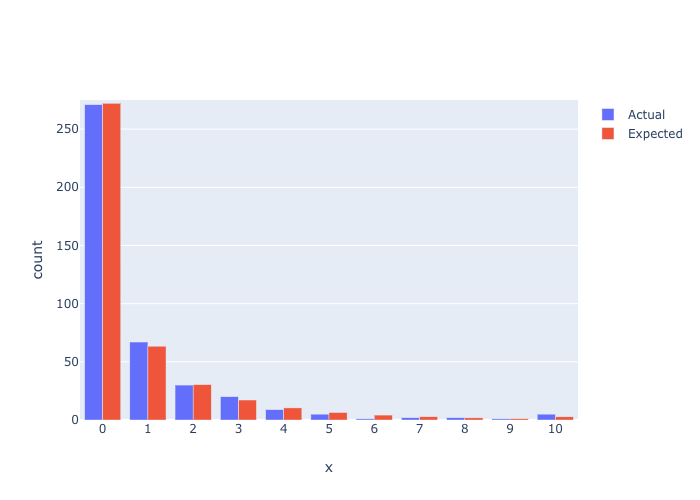

In [8]:
Image(filename='../images/nbd-figure-1.png')